In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from torchvision import transforms
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler

from umap import UMAP
from sklearn.cluster import DBSCAN

# Import Data

In [5]:
def import_rescaled_csv(folder_path):
    # List all CSV files in the given folder
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    csv_files_sorted = np.sort(np.array(csv_files))
    #print(csv_files_sorted)
    # Initialize an empty list to store the data arrays
    data_arrays = []

    indecies = np.zeros_like(csv_files_sorted, dtype=int)
    for i in range(len(csv_files_sorted)):
        indecies[i] = int(csv_files_sorted[i][:-6])
        #print(type(indecies[i]))
    #print(csv_files_sorted, indecies)
        
    
    # Iterate over the CSV files and read them into numpy arrays
    for file in csv_files_sorted:
        file_path = os.path.join(folder_path, file)
        data = pd.read_csv(file_path, header=None).values
        data_arrays.append(data)

    return data_arrays, indecies

In [6]:
data_raw, index = import_rescaled_csv('clusters_colour_rotations_rescaled/')

labels_raw = [np.load('./labels/'+x) for x in os.listdir('./labels/') if x.endswith('.npy')]
print(len(labels_raw[8][0]), len(labels_raw[8][1]))


label_dict = {}
value_array = []
for values in labels_raw:
    for value,ind in zip(values[0],values[1]):
        value_array.append(value)
        #print(value)
        label_dict[value] = ind

label = [label_dict[i_] for i_ in index]
label = np.array(label, dtype=int)

data_raw = np.array(data_raw)
data_raw = data_raw[(label != 4) * (label != 0)]
label = label[(label != 4) * (label != 0)] - 1



train_images, testval_images, train_labels, testval_labels = train_test_split(data_raw, label, test_size=0.2, random_state=13052020)

# further split testval set into specific test and validation set
# the test set is NOT used during any part but inference
val_images, test_images, val_labels, test_labels = train_test_split(testval_images, testval_labels, test_size=0.5, random_state=13052020)




119 119


# Normelize Data

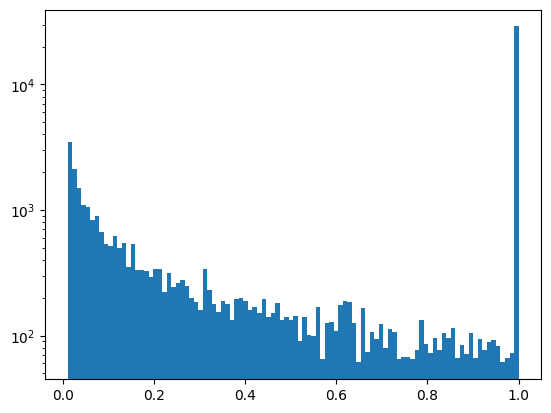

'\nnum_classes = 3 # number of classes\ntrain_labels = keras.utils.to_categorical(train_labels, num_classes)\nval_labels = keras.utils.to_categorical(val_labels, num_classes)\ntest_labels = keras.utils.to_categorical(test_labels, num_classes)\n'

In [8]:
from sklearn.preprocessing import RobustScaler



# save for scaling test data
mu_train = np.mean(train_images)
sigma_train = np.std(train_images)



scaler = RobustScaler()

scaler.fit(train_images.reshape(-1, 1))
train_images = scaler.transform(train_images.reshape(-1, 1)).reshape(train_images.shape)
val_images = scaler.transform(val_images.reshape(-1, 1)).reshape(val_images.shape)
#test_images = scaler.transform(test_images.reshape(-1, 1)).reshape(test_images.shape)

plt.hist(train_images.flatten(), bins=100, range=(0.01, 1))
plt.yscale('log')
plt.show()



# adapt to format required by tensorflow; Using channels_last --> (n_samples, img_rows, img_cols, n_channels)
img_rows, img_cols = 64, 64 # input image dimensions
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
val_images = val_images.reshape(val_images.shape[0], img_rows, img_cols, 1)
#test_images = val_images.reshape(test_images.shape[0], img_rows, img_cols, 1)

# convert class vectors to binary class matrices - one hot encoding
"""
num_classes = 3 # number of classes
train_labels = keras.utils.to_categorical(train_labels, num_classes)
val_labels = keras.utils.to_categorical(val_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)
"""


# Chosse device

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Create Model

In [ ]:
def create_tf_model_CNN(trial):
    N_conv_layers = trial.suggest_int('N_conv_layers', 1, 3)
    N_dense_layers = trial.suggest_int('N_dense_layers', 1, 3)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    model = Sequential()  # Network type is Sequential
    for i in range(N_conv_layers):
        model.add(Conv2D(filters=2**trial.suggest_int('conv_filter_exp'+str(i), 3, 7),
                         kernel_size=trial.suggest_int('conv_kernel_size'+str(i), 2, 5),
                         strides=1,
                         padding='same',
                         activation='relu'))
        model.add(MaxPooling2D(pool_size=2, strides=None))
    model.add(Dropout(rate=dropout_rate))
    model.add(Flatten())
    for i in range(N_dense_layers - 1):
        model.add(Dense(units=2**trial.suggest_int('dense_units_exp'+str(i), 3, 5), activation='relu'))
    model.add(Dense(units=num_classes, activation='softmax'))
    #model.summary()
    return model


def create_torch_model_CNN(trial):
    N_conv_layers = trial.suggest_int('N_conv_layers', 1, 3)
    N_dense_layers = trial.suggest_int('N_dense_layers', 1, 3)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    dropout_rate = 0.5
    num_classes = 3
    class torch_CNN(nn.Module):
        def __init__(self, output_size):
            super().__init()

            ### Convolutional section:
            self.cnn_layer = nn.Sequential(
                nn.Conv2d(1, 32, 3, stride=1, padding=1),  # 1x64x64 -> 32x64x64
                nn.ReLU(True),
                nn.Conv2d(32, 64, 3, stride=1, padding=1),  # 32x128x128 -> 64x64x64
                nn.ReLU(True),
                nn.MaxPool2d(2)  # 64x64x64 -> 64x32x32
            )

            ### Flattening:
            self.flatten = nn.Flatten(start_dim=0)

            ### Linerar section
            self.linerar_layer = nn.Sequential(
                nn.Linear(65536, 128),
                nn.ReLU(True)
            )

            ### output layer
            self.output_layer = nn.Sequential(
                nn.linear(128, output_size),
                nn.Softmax()
            )

            ### dropout
            self.dropout = nn.Dropout(dropout_rate, inplace=True)
        
        def create_CNN_layer(self, filters_in, filters_out):
            #filters_out = 32
            filter_size = 3
            stride_cnn = 1
            padding = 1
            pool_size = 2
            pool_stride = 1
            cnn_layer = nn.Sequential(
                nn.Conv2d(filters_in, filters_out, filter_size, stride=stride_cnn, padding=padding),  # 1x256x256 -> 32x128x128
                nn.ReLU(True),
                nn.MaxPool2d(pool_size, stride=pool_stride)  # 64x64x64 -> 64x32x32
            )
            return cnn_layer, filters_out
        
        def create_liniar_layer(self, input_size, output_size):
            liniar_layer = nn.Sequential(
                nn.Linear(input_size, output_size),
                nn.ReLU(True)
            )
            return liniar_layer, output_size
        
        def create_output_layer(self, input_size, output_size):
            output_layer = nn.Sequential(
                nn.linear(input_size, output_size),
                nn.Softmax()
            )
            return output_layer
        


        def forward(self, x):

            cnn_layer0, filters_out0 = self.create_CNN_layer(1, 32)
            x = cnn_layer0(x)
            cnn_layer1, filters_out1 = self.create_CNN_layer(filters_out0, 64)
            x = cnn_layer1(x)

            x = self.flatten(x)
            x = self.dropout(x)

            liniar_layer0, output_size0 = self.create_liniar_layer(65536, 128)
            x = liniar_layer0(x)
            liniar_layer1, output_size1 = self.create_liniar_layer(output_size0, 64)
            x = liniar_layer1(x)

            output_layer = self.create_output_layer(output_size1, num_classes)
            x = output_layer(x)
           
            return x
    return torch_CNN(num_classes).to(device)


def create_tf_optimizer(trial):
    # We optimize the choice of optimizers as well as their parameters.
    kwargs = {}
    
    optimizer_selected = "Adam"
    
    kwargs["learning_rate"] = trial.suggest_float("adam_learning_rate", 1e-7, 1e-1, log=True)

    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer

def objective(trial, X_train, Y_train, X_test, Y_test):
    # Build model and optimizer.
    model = create_tf_model_CNN(trial)
    optimizer = create_tf_optimizer(trial)
    model.compile(optimizer, loss=CategoricalCrossentropy())
    # Fit the model to the data
    model.fit(x=X_train, y = Y_train, epochs=30, validation_data=(X_test, Y_test), verbose=0)
    # Find the accuracy
    cce = CategoricalCrossentropy()
    accuracy = cce(Y_test, model(X_test))
    # Return accuracy
    return accuracy
